In [33]:
# EXPLORING DATA


import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# cria ou liga se já existir:
con = duckdb.connect("movielens100K.duckdb")

##### Tables from the original dataset
 - Movies:
    - movieID
    - title
    - genres
 - ratings:
    - userId
    - movieId
    - rating
    - timestamp
 - links:
    - moviesId
    - imdbId
    - tmdbId
 - tags:
    - userId
    - movieId
    - tag
    - timestamp




In [34]:
# Find the 20 movies with the highest rating (with at least 50 ratings)
df1 = con.sql("""
SELECT
    m.title,
    ROUND(AVG(r.rating), 2) AS media_rating,
    COUNT(*)                AS total_ratings
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
HAVING COUNT(*) > 50
ORDER BY media_rating DESC, total_ratings DESC
LIMIT 20
""").df()

df1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,title,media_rating,total_ratings
0,Planet Earth (2006),4.45,3015
1,Planet Earth II (2016),4.45,2041
2,"Shawshank Redemption, The (1994)",4.42,122296
3,Band of Brothers (2001),4.42,2835
4,Cosmos,4.34,625
5,"Godfather, The (1972)",4.33,75004
6,Parasite (2019),4.33,12399
7,Blue Planet II (2017),4.31,1267
8,Twelve Angry Men (1954),4.31,332
9,Twin Peaks (1989),4.30,1132


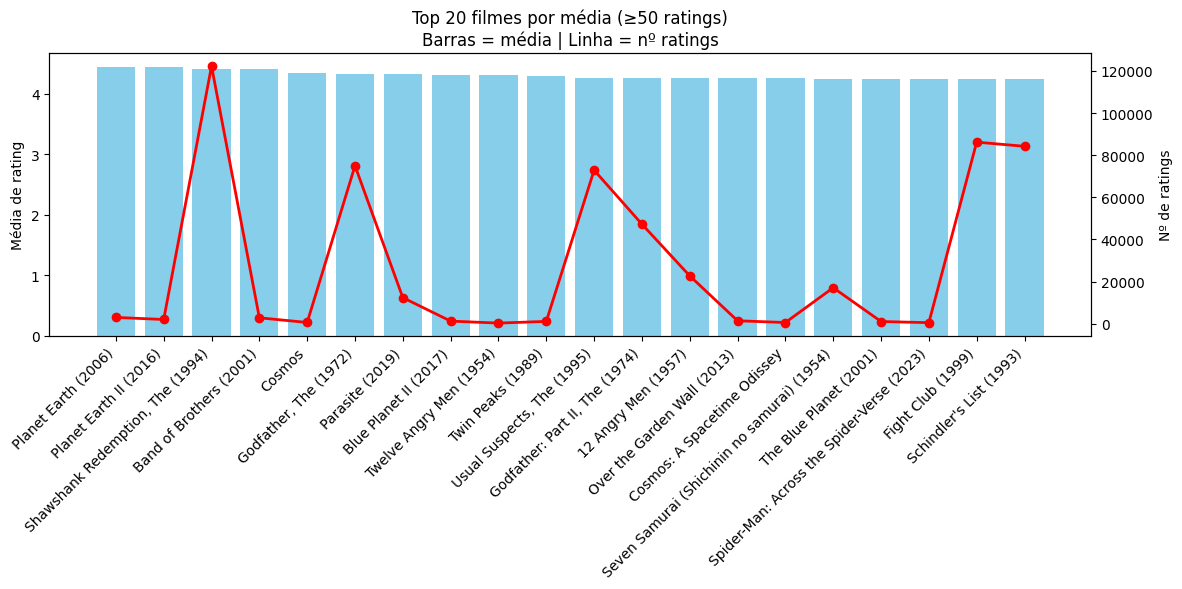

In [35]:
# combined plot: bars (average) + line (number of ratings)
fig, ax1 = plt.subplots(figsize=(12, 6))

# bars = average (BLUE)
ax1.bar(df1["title"], df1["media_rating"], color="skyblue")
ax1.set_ylabel("Média de rating")
ax1.set_xticks(range(len(df1)))
ax1.set_xticklabels(df1["title"], rotation=45, ha="right")

# rows = number of ratings (RED)
ax2 = ax1.twinx()
ax2.plot(range(len(df1)), df1["total_ratings"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Nº de ratings")

plt.title("Top 20 filmes por média (≥50 ratings)\nBarras = média | Linha = nº ratings")
plt.tight_layout()
plt.show()



In [36]:

# ranking of the 20 movies with the most ratings

df2 = con.sql("""
SELECT
    m.title,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
ORDER BY total_ratings DESC, media_rating DESC
LIMIT 20
""").df()

df2




FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,title,total_ratings,media_rating
0,"Shawshank Redemption, The (1994)",122296,4.42
1,Forrest Gump (1994),113581,4.07
2,Pulp Fiction (1994),108756,4.19
3,"Matrix, The (1999)",107056,4.16
4,"Silence of the Lambs, The (1991)",101802,4.15
5,Star Wars: Episode IV - A New Hope (1977),97202,4.09
6,Fight Club (1999),86207,4.24
7,Schindler's List (1993),84232,4.24
8,Jurassic Park (1993),83026,3.69
9,Star Wars: Episode V - The Empire Strikes Back...,80200,4.12


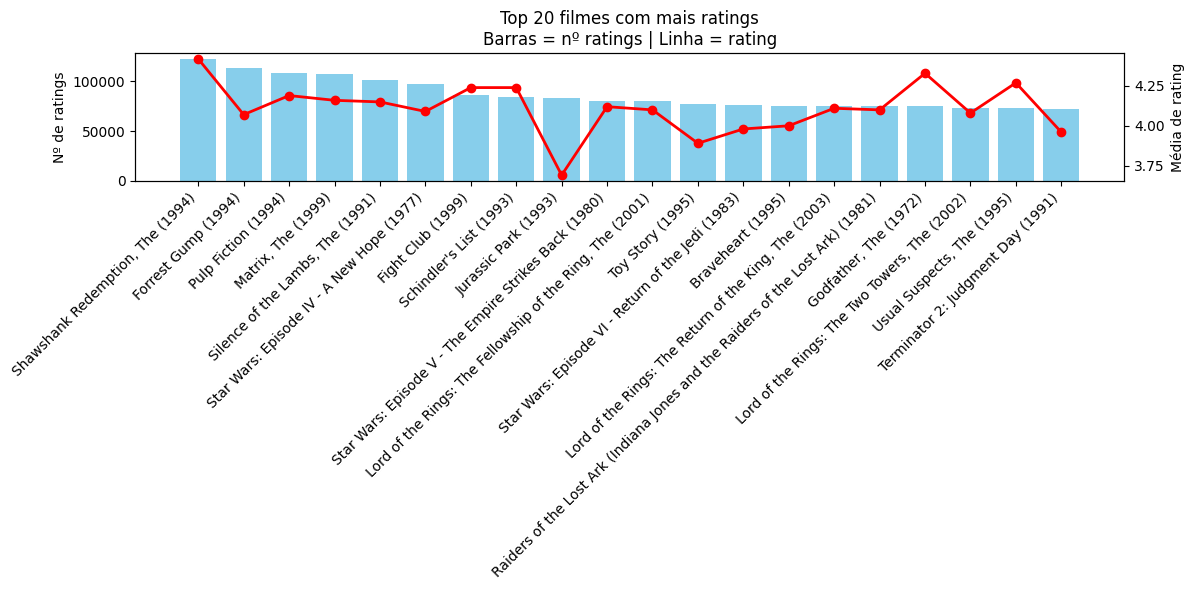

In [37]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras = nº ratings (azul)
ax1.bar(df2["title"], df2["total_ratings"], color="skyblue")
ax1.set_ylabel("Nº de ratings")
ax1.set_xticks(range(len(df2)))
ax1.set_xticklabels(df2["title"], rotation=45, ha="right")

# Linha = média (vermelho)
ax2 = ax1.twinx()
ax2.plot(range(len(df2)), df2["media_rating"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Média de rating")

plt.title("Top 20 filmes com mais ratings\nBarras = nº ratings | Linha = rating")
plt.tight_layout()
plt.show()


In [38]:
# =================================================================
# ranking dos filmes por genero (com pelo menos 50 avaliações)
# =================================================================
df3 = con.sql("""
WITH genero_filme AS (
    SELECT
        m.movieId,
        m.title,
        unnest(string_split(m.genres, '|')) AS genre
    FROM movies m
),
stats_genero_filme AS (
    SELECT
        gf.genre,
        gf.movieId,
        gf.title,
        COUNT(*) AS total_ratings,
        AVG(r.rating) AS media_rating
    FROM genero_filme gf
    JOIN ratings r
      ON r.movieId = gf.movieId
    GROUP BY gf.genre, gf.movieId, gf.title
    HAVING COUNT(*) >= 50          -- 👈 mínimo de 10 ratings
),
ranking_por_genero AS (
    SELECT
        genre,
        movieId,
        title,
        total_ratings,
        media_rating,
        ROW_NUMBER() OVER (
            PARTITION BY genre
            ORDER BY media_rating DESC, total_ratings DESC
        ) AS posicao
    FROM stats_genero_filme
)
SELECT
    genre,
    title,
    ROUND(media_rating, 2) AS media_rating,
    total_ratings
FROM ranking_por_genero
WHERE posicao = 1
ORDER BY genre
""").df()

df3

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,genre,title,media_rating,total_ratings
0,(no genres listed),Cosmos,4.34,625
1,Action,Band of Brothers (2001),4.42,2835
2,Adventure,Over the Garden Wall (2013),4.26,1430
3,Animation,Over the Garden Wall (2013),4.26,1430
4,Children,My Neighbor Totoro (Tonari no Totoro) (1988),4.16,14010
5,Comedy,Parasite (2019),4.33,12399
6,Crime,"Shawshank Redemption, The (1994)",4.42,122296
7,Documentary,Planet Earth II (2016),4.45,2041
8,Drama,Band of Brothers (2001),4.42,2835
9,Fantasy,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.23,35375


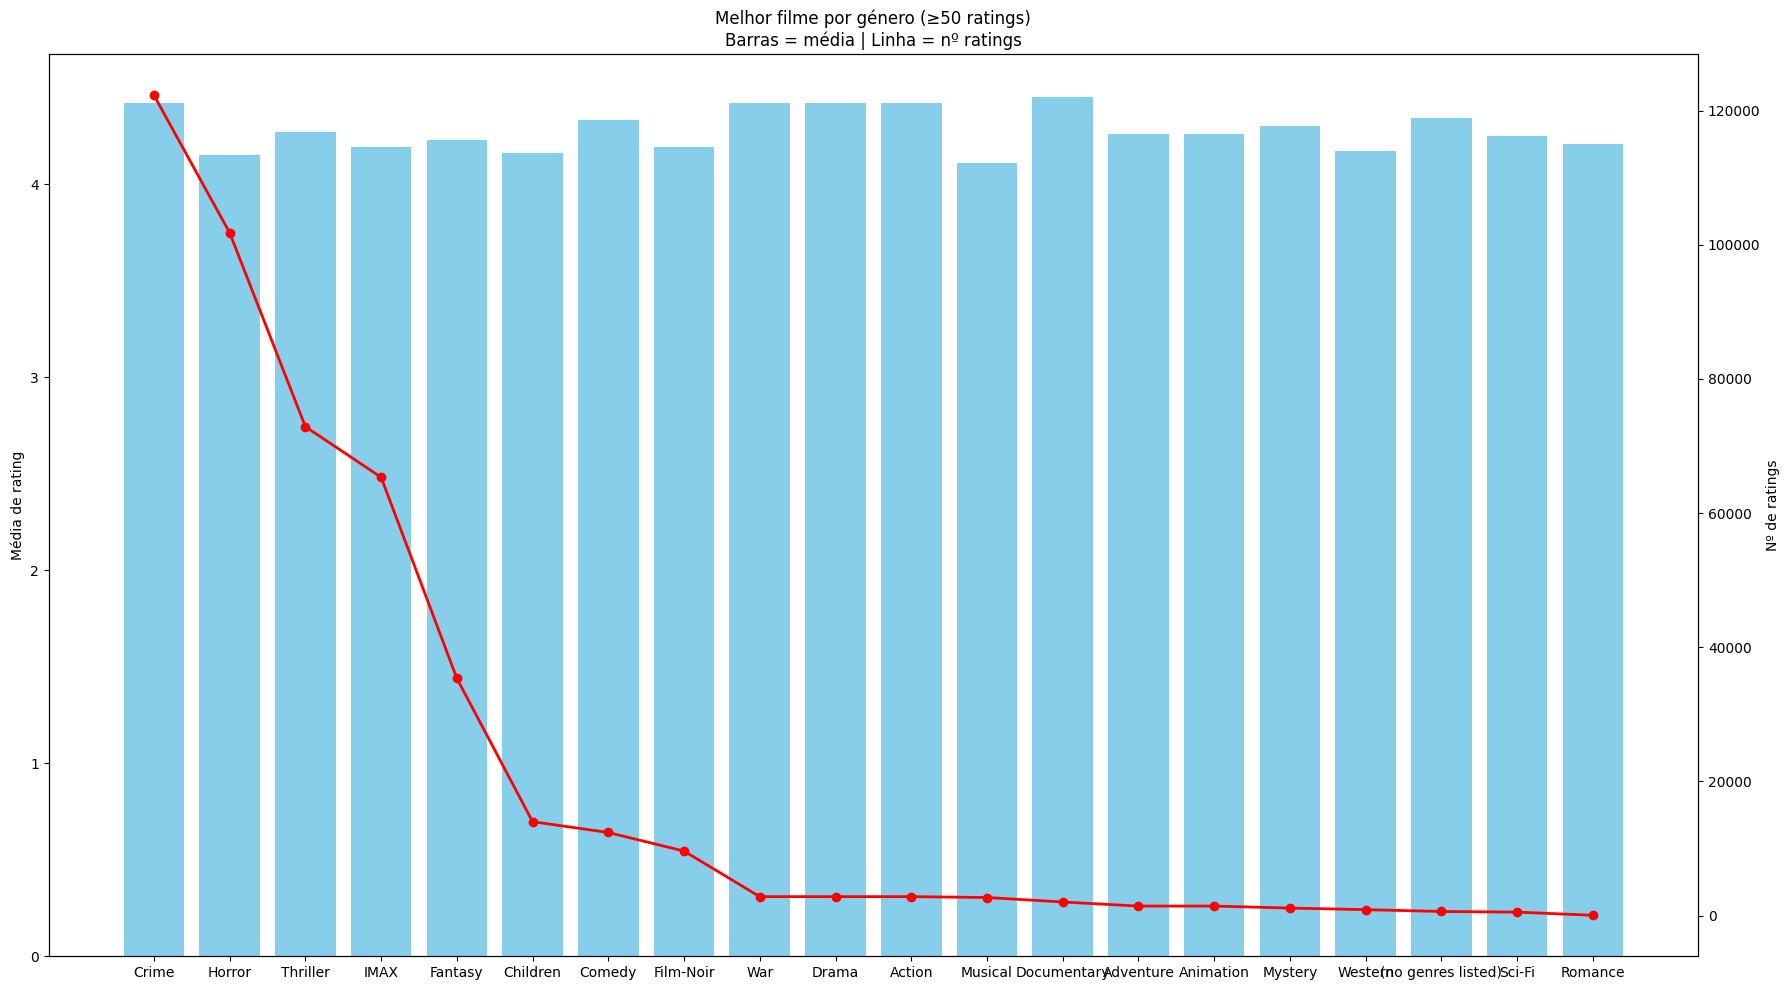

In [39]:
df3_plot = df3.sort_values("total_ratings", ascending=False)

x = np.arange(len(df3_plot))   # 0..N-1

fig, ax1 = plt.subplots(figsize=(18,10))
# Barras = média
ax1.bar(x, df3_plot["media_rating"], color="skyblue")
ax1.set_ylabel("Média de rating")

# Linha = nº ratings
ax2 = ax1.twinx()
ax2.plot(x, df3_plot["total_ratings"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Nº de ratings")

# Géneros como labels verticais
plt.xticks(x, df3_plot["genre"], rotation=90)
plt.title("Melhor filme por género (≥50 ratings)\nBarras = média | Linha = nº ratings")

plt.tight_layout()
plt.show()


In [40]:
# =================================================================
# ranking dos filmes + avaliados por genero (com pelo menos 50 avaliações)
# =================================================================

con.sql("""
WITH genero_filme AS (
    SELECT
        m.movieId,
        m.title,
        unnest(string_split(m.genres, '|')) AS genre
    FROM movies m
),
stats_genero_filme AS (
    SELECT
        gf.genre,
        gf.movieId,
        gf.title,
        COUNT(*) AS total_ratings,
        AVG(r.rating) AS media_rating
    FROM genero_filme gf
    JOIN ratings r
      ON r.movieId = gf.movieId
    GROUP BY gf.genre, gf.movieId, gf.title
    HAVING COUNT(*) >= 50  -- mantém só filmes com pelo menos 50 avaliações
),
ranking_por_genero AS (
    SELECT
        genre,
        movieId,
        title,
        total_ratings,
        media_rating,
        ROW_NUMBER() OVER (
            PARTITION BY genre
            ORDER BY total_ratings DESC, media_rating DESC
        ) AS posicao
    FROM stats_genero_filme
)
SELECT
    genre,
--    posicao,
    title,
    total_ratings,
    ROUND(media_rating, 2) AS media_rating
FROM ranking_por_genero
WHERE posicao <= 1
ORDER BY genre, posicao
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,genre,title,total_ratings,media_rating
0,(no genres listed),Hereditary (2018),4631,3.87
1,Action,"Matrix, The (1999)",107056,4.16
2,Adventure,Star Wars: Episode IV - A New Hope (1977),97202,4.09
3,Animation,Toy Story (1995),76813,3.89
4,Children,Toy Story (1995),76813,3.89
5,Comedy,Forrest Gump (1994),113581,4.07
6,Crime,"Shawshank Redemption, The (1994)",122296,4.42
7,Documentary,Bowling for Columbine (2002),16608,3.69
8,Drama,"Shawshank Redemption, The (1994)",122296,4.42
9,Fantasy,"Lord of the Rings: The Fellowship of the Ring,...",79940,4.10


In [41]:
# ================================================
# Saber os tags mais frequentes
# ================================================

con.sql("""
SELECT
    LOWER(TRIM(word)) AS palavra,
    COUNT(*) AS total
FROM (
    SELECT unnest(string_split(tag, ' ')) AS word
    FROM tags
)
WHERE palavra <> ''
  AND LENGTH(palavra) > 2
  AND palavra NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are')
GROUP BY palavra
ORDER BY total DESC
LIMIT 30
""").df()

,palavra,total
0,comedy,32686
1,based,22092
2,ending,19849
3,dark,18455
4,film,17807
5,relationship,17426
6,great,17283
7,nudity,16873
8,sci-fi,16492
9,action,15728


In [42]:
# ================================================
# Saber o tag mais repetido por filme:
# ================================================

df_tags=con.sql("""
WITH palavras_por_filme AS (
    SELECT
        t.movieId,
        LOWER(TRIM(word)) AS palavra,
        COUNT(*) AS total
    FROM (
        SELECT movieId, unnest(string_split(tag, ' ')) AS word
        FROM tags
    ) t
    WHERE palavra <> ''
      AND LENGTH(palavra) > 2
      AND palavra NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are', 'was')
    GROUP BY t.movieId, palavra
),
ranking_por_filme AS (
    SELECT
        movieId,
        palavra,
        total,
        ROW_NUMBER() OVER (PARTITION BY movieId ORDER BY total DESC) AS posicao
    FROM palavras_por_filme
)
SELECT
    m.movieId,
    m.title,
    r.palavra,
    r.total
FROM ranking_por_filme r
JOIN movies m USING (movieId)
WHERE r.posicao <= 5
ORDER BY r.total DESC
LIMIT 20
""").df()

df_tags

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,movieId,title,palavra,total
0,260,Star Wars: Episode IV - A New Hope (1977),space,1684
1,260,Star Wars: Episode IV - A New Hope (1977),sci-fi,1538
2,260,Star Wars: Episode IV - A New Hope (1977),classic,1089
3,109487,Interstellar (2014),space,809
4,260,Star Wars: Episode IV - A New Hope (1977),adventure,807
5,296,Pulp Fiction (1994),comedy,707
6,296,Pulp Fiction (1994),tarantino,700
7,318,"Shawshank Redemption, The (1994)",ending,665
8,2571,"Matrix, The (1999)",reality,663
9,2959,Fight Club (1999),ending,640


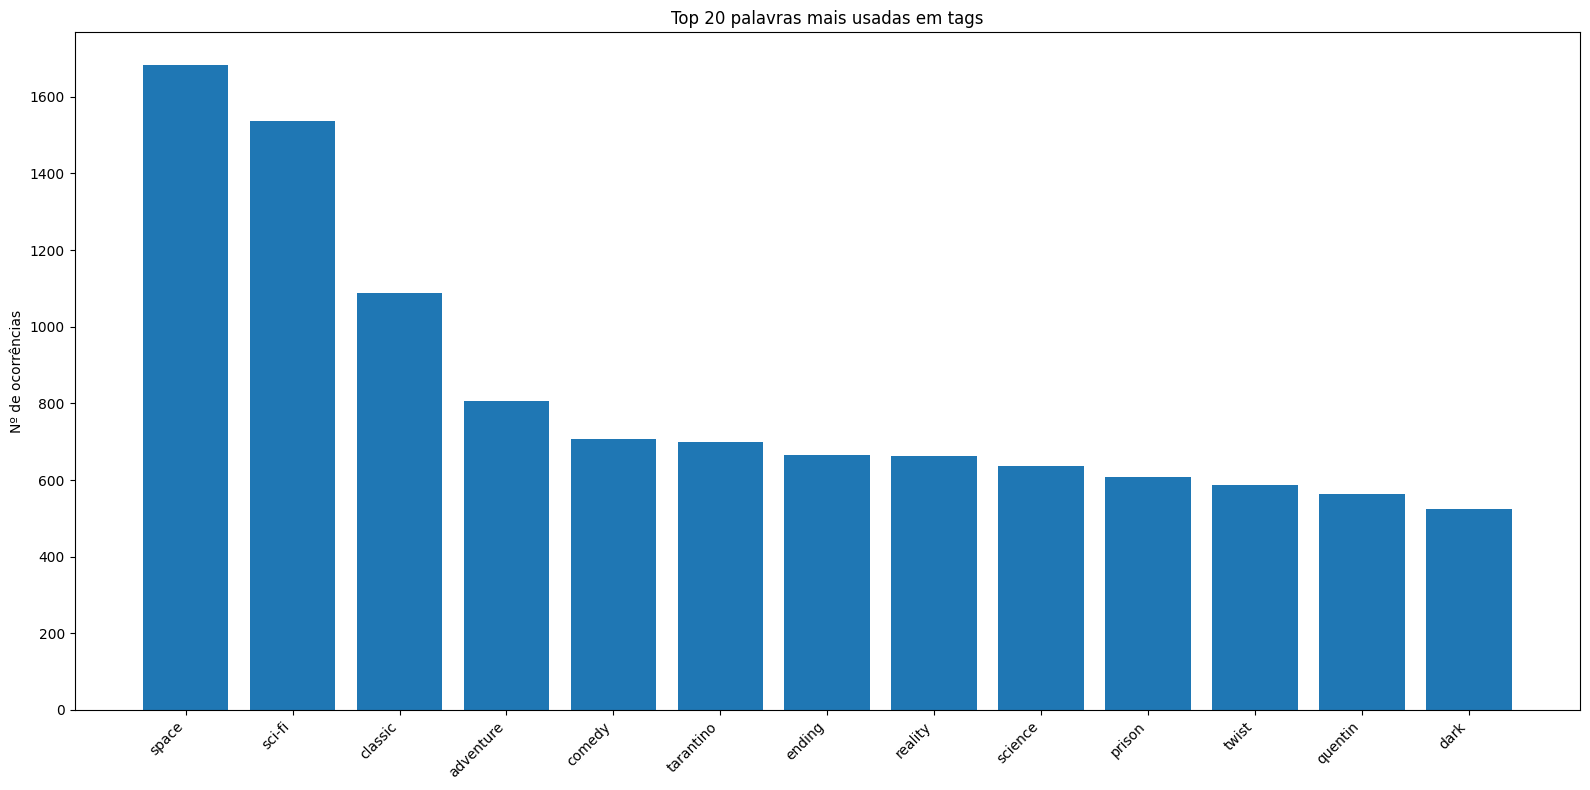

In [43]:
# Top 10 palavras
df_top = df_tags.sort_values("total", ascending=False).head(20)

plt.figure(figsize=(16,8))
plt.bar(df_top["palavra"], df_top["total"])
plt.title("Top 20 palavras mais usadas em tags")
plt.ylabel("Nº de ocorrências")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [44]:
# ================================================
# Saber os users com mais qt de ratings e nota média
# ================================================

con.sql("""
SELECT
    r.userId,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
GROUP BY r.userId
ORDER BY total_ratings DESC, media_rating DESC
LIMIT 20
""").df()

,userId,total_ratings,media_rating
0,189614,33332,3.08
1,48766,9554,2.57
2,207216,9178,3.28
3,175998,9016,3.18
4,76618,8919,2.54
5,230765,7719,3.41
6,184775,7535,2.82
7,236260,7488,3.21
8,233891,7372,2.64
9,214831,7266,1.55


In [45]:
df_users = con.sql("""
SELECT
    userId,
    COUNT(*) AS total_ratings,
    ROUND(AVG(rating), 2) AS media_rating
FROM ratings
GROUP BY userId
""").df()


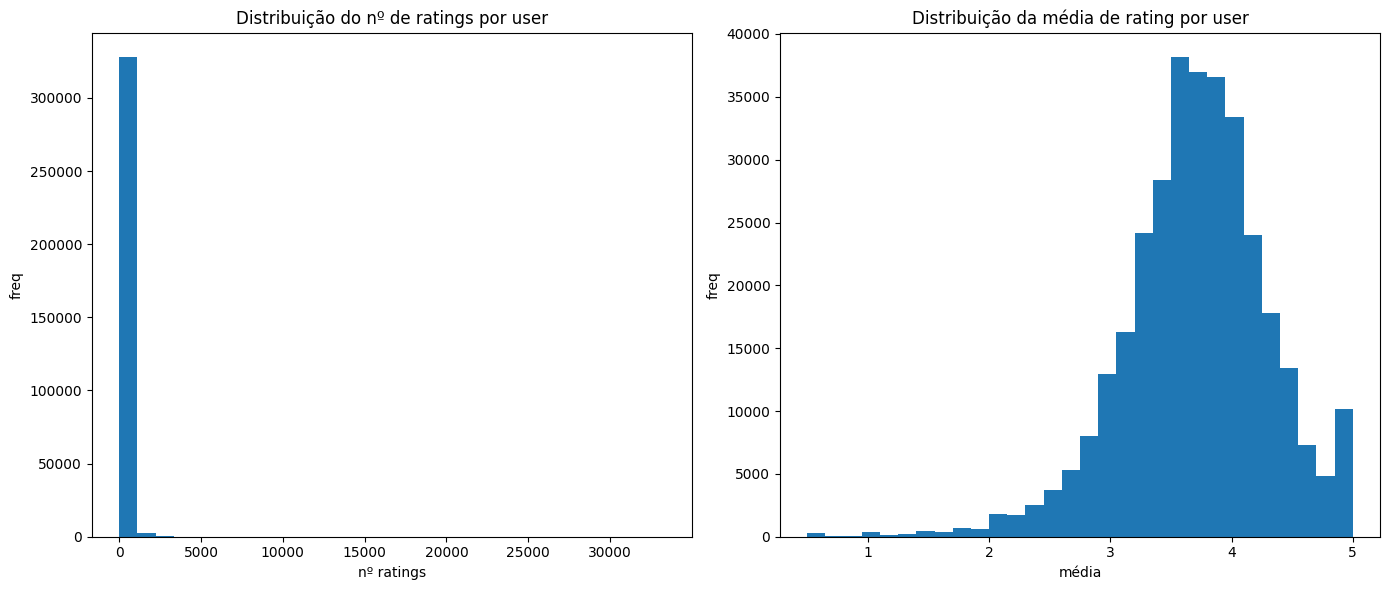

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# hist nº ratings
axes[0].hist(df_users["total_ratings"], bins=30)
axes[0].set_title("Distribuição do nº de ratings por user")
axes[0].set_xlabel("nº ratings")
axes[0].set_ylabel("freq")

# hist média ratings
axes[1].hist(df_users["media_rating"], bins=30)
axes[1].set_title("Distribuição da média de rating por user")
axes[1].set_xlabel("média")
axes[1].set_ylabel("freq")

plt.tight_layout()
plt.show()


#### Fechar a ligação

In [47]:
con.close()
print("Ligação fechada.")

Ligação fechada.
